In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))  # Only if device_count > 0

train_loader = torch.load('train_dataloader_aug.pth', weights_only=False)
test_loader = torch.load('test_dataloader_aug.pth', weights_only=False)

True
1
NVIDIA GeForce RTX 2060


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionRecognition(nn.Module):
    def __init__(self):
        super(EmotionRecognition, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Convolutional Block 2
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Global Average Pooling Layer
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(64, 512)
        self.fc2 = nn.Linear(512, 7)

        # Xavier Initialization
        self.apply(self.weights_init)

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def _forward_conv(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [4]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # class weights
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)  # pt = probability of the true class
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [7]:
import torch
import torch.optim as optim
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed(42)

model = EmotionRecognition().to(device)
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_loader.dataset.targets),
                                     y=train_loader.dataset.targets)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = FocalLoss(alpha=class_weights_tensor, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Cosine Annealing Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Mixed Precision Setup
scaler = torch.cuda.amp.GradScaler() if device.type == "cuda" else None


C:\Users\Korisnik\AppData\Local\Temp\ipykernel_3676\972021495.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == "cuda" else None


In [8]:
best_loss = float('inf')
patience = 10
epochs_no_improve = 0
num_epochs = 100
save_path = "best_model.pth"

In [9]:
for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=scaler is not None):
            outputs = model(images)
            loss = criterion(outputs, labels)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_loss = total_loss / total_samples
    train_acc = 100. * total_correct / total_samples

    # Evaluate the model on the test set
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100. * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

    # Update learning rate scheduler
    scheduler.step()

    # Print epoch results
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

    # Early stopping
    if train_loss < best_loss:
        best_loss = train_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print("✅ Saved new best model.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("⏹ Early stopping triggered.")
            break

Training:   0%|          | 0/449 [00:00<?, ?it/s]C:\Users\Korisnik\AppData\Local\Temp\ipykernel_3676\4092488656.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):



Epoch 1/100
Train Loss: 1.3825, Train Acc: 16.26% | Test Acc: 19.48%
Learning Rate: 0.000976
✅ Saved new best model.



Epoch 2/100
Train Loss: 1.3343, Train Acc: 17.99% | Test Acc: 15.88%
Learning Rate: 0.000905
✅ Saved new best model.



Epoch 3/100
Train Loss: 1.2766, Train Acc: 20.68% | Test Acc: 25.29%
Learning Rate: 0.000794
✅ Saved new best model.



Epoch 4/100
Train Loss: 1.2352, Train Acc: 22.32% | Test Acc: 14.85%
Learning Rate: 0.000655
✅ Saved new best model.



Epoch 5/100
Train Loss: 1.2060, Train Acc: 22.91% | Test Acc: 24.80%
Learning Rate: 0.000501
✅ Saved new best model.



Epoch 6/100
Train Loss: 1.1735, Train Acc: 25.22% | Test Acc: 32.43%
Learning Rate: 0.000346
✅ Saved new best model.



Epoch 7/100
Train Loss: 1.1424, Train Acc: 28.02% | Test Acc: 26.41%
Learning Rate: 0.000207
✅ Saved new best model.



Epoch 8/100
Train Loss: 1.1157, Train Acc: 28.99% | Test Acc: 21.57%
Learning Rate: 0.000096
✅ Saved new best model.



Epoch 9/100
Train Loss: 1.0965, Train Acc: 30.61% | Test Acc: 29.09%
Learning Rate: 0.000025
✅ Saved new best model.



Epoch 10/100
Train Loss: 1.0830, Train Acc: 30.83% | Test Acc: 32.33%
Learning Rate: 0.000001
✅ Saved new best model.



Epoch 11/100
Train Loss: 1.0755, Train Acc: 31.20% | Test Acc: 32.64%
Learning Rate: 0.000025
✅ Saved new best model.



Epoch 12/100
Train Loss: 1.0768, Train Acc: 32.11% | Test Acc: 33.00%
Learning Rate: 0.000096



Epoch 13/100
Train Loss: 1.0739, Train Acc: 31.43% | Test Acc: 32.96%
Learning Rate: 0.000207
✅ Saved new best model.



Epoch 14/100
Train Loss: 1.0693, Train Acc: 32.44% | Test Acc: 35.64%
Learning Rate: 0.000346
✅ Saved new best model.



Epoch 15/100
Train Loss: 1.0825, Train Acc: 31.91% | Test Acc: 32.91%
Learning Rate: 0.000501



Epoch 16/100
Train Loss: 1.0880, Train Acc: 31.84% | Test Acc: 37.99%
Learning Rate: 0.000655



Epoch 17/100
Train Loss: 1.0802, Train Acc: 32.98% | Test Acc: 32.96%
Learning Rate: 0.000794



Epoch 18/100
Train Loss: 1.0769, Train Acc: 33.53% | Test Acc: 38.92%
Learning Rate: 0.000905



Epoch 19/100
Train Loss: 1.0724, Train Acc: 34.71% | Test Acc: 35.97%
Learning Rate: 0.000976



Epoch 20/100
Train Loss: 1.0579, Train Acc: 35.58% | Test Acc: 28.55%
Learning Rate: 0.001000
✅ Saved new best model.



Epoch 21/100
Train Loss: 1.0427, Train Acc: 36.95% | Test Acc: 40.18%
Learning Rate: 0.000976
✅ Saved new best model.



Epoch 22/100
Train Loss: 1.0212, Train Acc: 38.09% | Test Acc: 33.28%
Learning Rate: 0.000905
✅ Saved new best model.



Epoch 23/100
Train Loss: 0.9960, Train Acc: 39.44% | Test Acc: 39.57%
Learning Rate: 0.000794
✅ Saved new best model.



Epoch 24/100
Train Loss: 0.9791, Train Acc: 40.72% | Test Acc: 47.21%
Learning Rate: 0.000655
✅ Saved new best model.



Epoch 25/100
Train Loss: 0.9375, Train Acc: 42.12% | Test Acc: 44.00%
Learning Rate: 0.000501
✅ Saved new best model.



Epoch 26/100
Train Loss: 0.9119, Train Acc: 43.17% | Test Acc: 40.11%
Learning Rate: 0.000346
✅ Saved new best model.



Epoch 27/100
Train Loss: 0.8897, Train Acc: 44.26% | Test Acc: 43.84%
Learning Rate: 0.000207
✅ Saved new best model.



Epoch 28/100
Train Loss: 0.8635, Train Acc: 45.51% | Test Acc: 47.26%
Learning Rate: 0.000096
✅ Saved new best model.



Epoch 29/100
Train Loss: 0.8427, Train Acc: 46.26% | Test Acc: 48.20%
Learning Rate: 0.000025
✅ Saved new best model.



Epoch 30/100
Train Loss: 0.8336, Train Acc: 46.98% | Test Acc: 49.39%
Learning Rate: 0.000001
✅ Saved new best model.



Epoch 31/100
Train Loss: 0.8158, Train Acc: 47.25% | Test Acc: 48.59%
Learning Rate: 0.000025
✅ Saved new best model.



Epoch 32/100
Train Loss: 0.8214, Train Acc: 46.99% | Test Acc: 50.18%
Learning Rate: 0.000096



Epoch 33/100
Train Loss: 0.8264, Train Acc: 47.34% | Test Acc: 49.29%
Learning Rate: 0.000207



Epoch 34/100
Train Loss: 0.8403, Train Acc: 46.39% | Test Acc: 48.58%
Learning Rate: 0.000346



Epoch 35/100
Train Loss: 0.8537, Train Acc: 45.66% | Test Acc: 30.83%
Learning Rate: 0.000501



Epoch 36/100
Train Loss: 0.8668, Train Acc: 44.90% | Test Acc: 48.98%
Learning Rate: 0.000655



Epoch 37/100
Train Loss: 0.8732, Train Acc: 44.84% | Test Acc: 46.89%
Learning Rate: 0.000794



Epoch 38/100
Train Loss: 0.8942, Train Acc: 44.25% | Test Acc: 40.44%
Learning Rate: 0.000905



Epoch 39/100
Train Loss: 0.8949, Train Acc: 43.90% | Test Acc: 43.54%
Learning Rate: 0.000976



Epoch 40/100
Train Loss: 0.9018, Train Acc: 43.77% | Test Acc: 44.27%
Learning Rate: 0.001000



Epoch 41/100
Train Loss: 0.8759, Train Acc: 44.32% | Test Acc: 47.59%
Learning Rate: 0.000976
⏹ Early stopping triggered.



Classification Report:
              precision    recall  f1-score   support

       Angry       0.38      0.35      0.36       958
     Disgust       0.12      0.68      0.20       111
        Fear       0.31      0.16      0.21      1024
       Happy       0.85      0.61      0.71      1774
         Sad       0.49      0.51      0.50      1233
    Surprise       0.39      0.43      0.41      1247
     Neutral       0.56      0.80      0.66       831

    accuracy                           0.49      7178
   macro avg       0.44      0.51      0.44      7178
weighted avg       0.52      0.49      0.49      7178



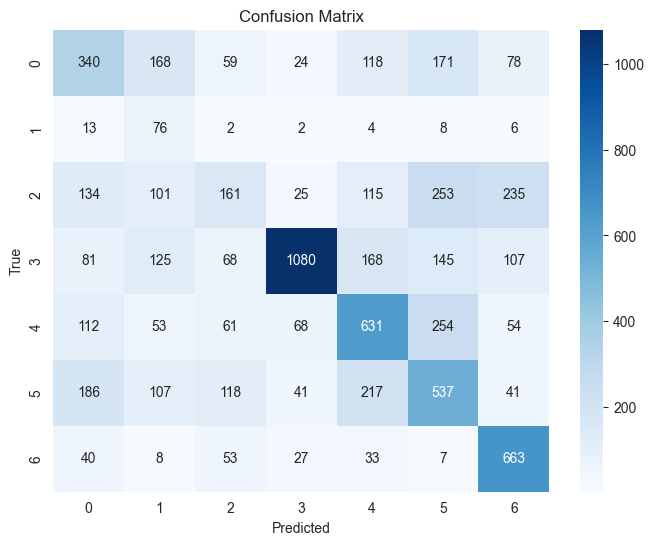

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

model.load_state_dict(torch.load(save_path))
model.eval()

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()